# MMB Model Frontiers based on a PI policy rule

## Optimization file only

If you are on the **monetaryPolicy** project, please use other file `PyLab.ipynb` for your analysis.

This cell sets up the notebook to import numpy, seaborn, pandas, matplotlib etc.

In [1]:
# Run this cell to set up the notebook.

# These lines import the Numpy, Pandas, Seaborn, Matplotlib modules.
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt

# Importing plotting libraries and styles
%matplotlib inline
plt.style.use('fivethirtyeight')

# For Pandas to ignore FutureWarning displays
import warnings
warnings.simplefilter('ignore', FutureWarning)

Install `matlab.engine` using this link:

https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html

### The cell given below sets up MATLAB for the notebook
Source: https://sehyoun.com/blog/20180904_using-matlab-with-jupyter-notebook.html

In [2]:
import matlab.engine
import io
import scipy.io
from IPython.core.magic import register_cell_magic
ip = get_ipython()

out = io.StringIO()
err = io.StringIO()

# Setup matlab cell magic #
@register_cell_magic
def matlab_magic(line,cell):
    out.truncate(0)
    out.seek(0)
    err.truncate(0)
    err.truncate(0)
    raw = '''{line}.eval("""{cell}""", nargout=0, stdout=out, stderr=err)'''
    ip.run_cell(raw.format(line=line, cell=cell))
    print(out.getvalue())
    print(err.getvalue())
    
# Starting a MATLAB engine called eng
eng = matlab.engine.start_matlab()

**Note:** Change this to the file path on your computer.

In [3]:
# Adds the MMB.m as well as MMBOPT1.m and MMBOPT2.m folders to the MATLAB engine path"
eng.addpath(r'/Users/Desktop/monetaryPolicy/mmb-gui-mlab-2.3.2', nargout=0)
eng.addpath(r'/Users/Desktop/monetaryPolicy/mmb-gui-mlab-2.3.2/MMB_OPTIONS', nargout=0)
eng.addpath(r'/Users/Desktop/monetaryPolicy/scripts', nargout=0)

# Important:
The code below sets the coefficients and other data for the PID rule to work.

Check out the coefficients table here:

https://rishab231.github.io/img/coefficients.png

In [4]:
# This sets the coefficients of the monetary policy rule, there are 33 coefficients and len(coefficients) = 33
coefficients = [0, 0, 0, 0, 1.5/4, 1.5/4, 1.5/4, 1.5/4, 
                0, 0, 0, 0, 0, 0.5, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 1, 0.25]

# Number of the model you want to chooose, please exclude 69-79, 19-22, 27, 59, 65, 68, 81, 97, 98
modelNum = 1

scipy.io.savemat('variables.mat', dict(coefficients=coefficients, modelNumber = modelNum))

## **Important:** 
The cell below runs the MMB.m file

In [5]:
eng.MMB(nargout = 0)

### Functions defined to import data for:
* 4 IRF: Impulse Response Function Variables (outputgap, inflation, interest, output) and `modelName`
* All IRF Variables
* 4 ACF: Autocorrelation Function Variables (outputgap, inflation, interest, output)
* **Unconditional Variances**


In [6]:
def getModelName():
    irf_4 = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "IRF Mon. Pol. Shock      ")
    irf_4 = irf_4.T
    irf_headers = irf_4.iloc[0] # grab the first row for the header
    irf_4 = irf_4[1:] # take the data less the header row
    irf_4_stripped_headers = [myHeader.strip() for myHeader in np.array(irf_headers)] # removing trailing whitespaces
    irf_4.columns = irf_4_stripped_headers
    modelName = irf_4.columns.values[1]
    return modelName

def singleModel_irf4():
    irf_4 = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "IRF Mon. Pol. Shock      ")
    irf_4 = irf_4.T
    irf_headers = irf_4.iloc[0] # grab the first row for the header
    irf_4 = irf_4[1:] # take the data less the header row
    irf_4_stripped_headers = [myHeader.strip() for myHeader in np.array(irf_headers)] # removing trailing whitespaces
    irf_4.columns = irf_4_stripped_headers
    modelName = irf_4.columns.values[1]
    irf_4 = irf_4.iloc[:, [i for i in range(1, len(irf_4.columns.values), 2)]]
    irf_4.columns = ["OutputGap", "Inflation", "Interest", "Output"]
    irf_4 = irf_4.reset_index()
    irf_4.index.name = "Period"
    irf_4.drop('index', axis=1, inplace=True)
    return irf_4

def singleModel_allirf():
    old_irf_df = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "all IRFs Mon. Pol. Shock")
    all_irf = old_irf_df.T
    new_header = all_irf.iloc[0] # grab the first row for the header
    all_irf = all_irf[1:] # take the data less the header row
    stripped_headers = [myHeader.strip() for myHeader in np.array(new_header)] # removing trailing whitespaces
    all_irf.columns = stripped_headers # set the header row as the df header
    all_irf["c_t"] = all_irf.index
    all_irf.index = np.arange(0,21,1)
    all_irf.index.name = "Period"

    # This section rearranges the columns
    n = len(list(all_irf.columns.values))
    rearranged = [list(all_irf.columns.values)[-1]] + list(all_irf.columns.values)[:n-1]
    all_irf = all_irf[rearranged]
    return all_irf

def singleModel_acf():
    acf = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "ACF")
    acf = acf.T
    acf_headers = acf.iloc[0] # grab the first row for the header
    acf = acf[1:] # take the data less the header row
    acf_stripped_headers = [myHeader.strip() for myHeader in np.array(acf_headers)] # removing trailing whitespaces
    acf.columns = acf_stripped_headers
    acf = acf.iloc[:, [i for i in range(0, len(acf.columns.values), 2)]]
    acf.columns = ["OutputGap", "Inflation", "Interest", "Output"]
    acf = acf.reset_index()
    acf.index.name = "Period"
    acf.drop('index', axis=1, inplace=True)
    return acf

def unconditionalVariances():
    var4 = pd.read_csv("../mmb-gui-mlab-2.3.2/OUTPUT/variances.csv", names=["interest", "inflation", "outputgap", "output"])
    return var4

In [7]:
singleModel_irf4().head(3)

,OutputGap,Inflation,Interest,Output
Period,,,,
0,0,0,0,0
1,-0.823109,-0.0181086,0.561283,-0.823109
2,0.0414876,-0.0161234,-0.00344134,0.0414876


In [8]:
singleModel_acf().head(3)

,OutputGap,Inflation,Interest,Output
Period,,,,
0,1,1,1,1
1,0.661577,0.716781,0.755958,0.730718
2,0.375576,0.478675,0.590853,0.520949



Calculating `unconditionalVariances` for different models, in an array of `modelNums`

In [9]:
def myVariance(modelNums, coeff):
    variances = dict()
    for modelNum in modelNums:
        eng.MMB(nargout = 0)
        scipy.io.savemat('variables.mat', dict(coefficients=coeff, modelNumber = modelNum))
        modelName = getModelName()
        variances[modelName] = unconditionalVariances().values.tolist()[0]
    return variances

Calculating unconditional variances for different rules

In [10]:
myVariance([1], coefficients)

{'NK_RW97': [0.079687, 0.06191, 0.38900999999999997, 1.1702]}

## Hawkins PI Optimization (Williams Paper)

`selected_coeff` has $\beta^{(\pi_t)}, \beta^{(\pi_{t-1})}, \beta^{(y_t)}, \beta^{(y_{t-1})}$ 

So, the policy rule becomes:

$r_t = r_{t-1} + \beta^{(\pi_t)}\pi_t + \beta^{(\pi_{t-1})}\pi_{t-1} + \beta^{(y_t)}y_t + \beta^{(y_{t-1})}y_{t-1}$

In [11]:
PID_final_inflation_variance = 0
PID_final_output_gap_variance = 0
PID_final_interest_variance = 0
currentPIDLoss = 0

def myPID(selected_coeff, lambdaVal, coeffInterest, modelNum, rVarTarget):
    global PID_final_inflation_variance
    global PID_final_output_gap_variance
    global PID_final_interest_variance
    global currentPIDLoss

    coefficients = [1, 0, 0, 0, 
                    abs(selected_coeff[0])/4, 
                    (abs(selected_coeff[0])+selected_coeff[1])/4, 
                    (abs(selected_coeff[0])+selected_coeff[1])/4, 
                    (abs(selected_coeff[0])+selected_coeff[1])/4, 
                    selected_coeff[1]/4, 
                    0, 0, 0, 0, 
                    selected_coeff[2], selected_coeff[3], 0, 
                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.25]    
    scipy.io.savemat('variables.mat', dict(coefficients=coefficients, modelNumber = modelNum)) # Input for MMB.
    eng.MMB(nargout = 0)
    
    interest_rate_variance = unconditionalVariances()['interest'][0]
    inflation_variance = unconditionalVariances()['inflation'][0]
    output_gap_variance = unconditionalVariances()['outputgap'][0]
    
    PID_final_inflation_variance = inflation_variance
    PID_final_output_gap_variance = output_gap_variance
    PID_final_interest_variance = interest_rate_variance
    
    PID_loss = ((interest_rate_variance - rVarTarget)**2 * coeffInterest 
                + inflation_variance * lambdaVal
                + output_gap_variance * (1 - lambdaVal))
    
    currentPIDLoss = PID_loss
    print("lambda =", lambdaVal, "current_loss =", currentPIDLoss)
    
    return PID_loss

In [12]:
def createFrontier(modelNum):
    rVarTarget = 16.0 # Target rate variance from Williams paper.
    taylor_coeff = [1.5, 0, 0.5, 0] # Taylor rule coefficients.
    hamilton_coeff = [1.42, -1.20, 0.5, -0.48] # Hamilton fit coefficients.
    weights = np.arange(0, 1.01, .25) # Values for lambda
    interest_coeff = 1.0 # Coefficient on the interest_rate loss term
    
    mylambdatemp = 0.0 # Something to put in the lambda variable when calculating the target rate variance.
    # Run with Hamilton coefficients to generate target rate variance.
    myfoo = myPID(hamilton_coeff, mylambdatemp, interest_coeff, modelNum, rVarTarget)
    rVarTarget = unconditionalVariances()['interest'][0] # Assign target rate variance.
    print("The target rate variance is", rVarTarget) # Print assigned rate variance.
    
    PID_inflation_variances = []
    PID_output_gap_variances = []
    PID_interest_variances = []
    PID_loss_of_lambda = []
    PID_coefficients_array = []

    # Starting with the Taylor rule coefficients
    #current_coeff = taylor_coeff
    
    # Starting with the Hamilton rule coefficients
    current_coeff = hamilton_coeff

    for lambda_value in weights:
        PID_result = scipy.optimize.minimize(myPID, current_coeff, \
                                    args=(lambda_value, interest_coeff, modelNum, rVarTarget), method='Nelder-Mead')
        current_coeff = PID_result.x
        PID_coefficients_array.append(current_coeff)
        PID_inflation_variances.append(PID_final_inflation_variance)
        PID_output_gap_variances.append(PID_final_output_gap_variance)
        PID_interest_variances.append(PID_final_interest_variance)
        PID_loss_of_lambda.append(currentPIDLoss)
    
    # The code below plots the frontier
    nameOfModel = getModelName()
    
    SD_inflation_scatter = np.sqrt(np.asarray(PID_inflation_variances))
    SD_output_gap_scatter = np.sqrt(np.asarray(PID_output_gap_variances))

    fig, ax = plt.subplots()
    ax.scatter(SD_inflation_scatter, SD_output_gap_scatter, color="red")

    for i in range(0, len(weights)):
        ax.annotate(weights[i], (SD_inflation_scatter[i], SD_output_gap_scatter[i]))

    ax.set_xlabel('$\sigma_{\pi}$', fontsize=10)
    ax.set_ylabel('$\sigma_{y}$', fontsize=10)
    ax.set_title('Policy Frontiers for Different Weights, Model: ' + nameOfModel, fontsize=14)
    
    # The code below saves the results of the all the optimizations with the appropriate lambdas into a DataFrame
    results = dict()
    results['lambdas'] = weights
    results['inflation_variance'] = PID_inflation_variances
    results['output_gap_variance'] = PID_output_gap_variances
    results['interest_variance'] = PID_interest_variances
    results['loss'] = PID_loss_of_lambda
    results['coefficients'] = PID_coefficients_array
    results_df = pd.DataFrame.from_dict(results)
    
    # Saving DataFrame to nameOfModel.csv file
    results_df.to_csv(nameOfModel + ".csv", index=False)
    
    return results_df

In [13]:
m15results = createFrontier(15)

lambda = 0.0 current_loss = 95.195944
The target rate variance is 22.712
lambda = 0.0 current_loss = 50.145
lambda = 0.0 current_loss = 49.301324
lambda = 0.0 current_loss = 83.28424400000003
lambda = 0.0 current_loss = 41.978401
lambda = 0.0 current_loss = 98.97032400000003
lambda = 0.0 current_loss = 43.530401
lambda = 0.0 current_loss = 39.797743999999994
lambda = 0.0 current_loss = 32.041241
lambda = 0.0 current_loss = 32.382321000000005
lambda = 0.0 current_loss = 32.86604899999999
lambda = 0.0 current_loss = 28.312943999999998
lambda = 0.0 current_loss = 43.439944
lambda = 0.0 current_loss = 44.444049000000014
lambda = 0.0 current_loss = 39.997009
lambda = 0.0 current_loss = 28.859889000000006
lambda = 0.0 current_loss = 43.94340900000001
lambda = 0.0 current_loss = 28.986881000000004
lambda = 0.0 current_loss = 30.41559999999999
lambda = 0.0 current_loss = 26.4956
lambda = 0.0 current_loss = 30.891728999999994
lambda = 0.0 current_loss = 26.072644
lambda = 0.0 current_loss = 29.

lambda = 0.0 current_loss = 12.906025
lambda = 0.0 current_loss = 12.903801
lambda = 0.0 current_loss = 12.899844
lambda = 0.0 current_loss = 12.896641
lambda = 0.0 current_loss = 12.891903999999998
lambda = 0.0 current_loss = 12.880161000000001
lambda = 0.0 current_loss = 12.865025000000001
lambda = 0.0 current_loss = 12.878876
lambda = 0.0 current_loss = 12.869769000000002
lambda = 0.0 current_loss = 12.877756
lambda = 0.0 current_loss = 12.847716000000002
lambda = 0.0 current_loss = 12.835124
lambda = 0.0 current_loss = 12.870049000000002
lambda = 0.0 current_loss = 12.835724
lambda = 0.0 current_loss = 12.868401
lambda = 0.0 current_loss = 12.820744
lambda = 0.0 current_loss = 12.798395999999999
lambda = 0.0 current_loss = 12.812615999999998
lambda = 0.0 current_loss = 12.779281000000001
lambda = 0.0 current_loss = 12.775504000000002
lambda = 0.0 current_loss = 12.789796
lambda = 0.0 current_loss = 12.7136
lambda = 0.0 current_loss = 12.658025
the MATLAB function has been cancelled

MatlabExecutionError: 
  File /Users/rishabsrivastava/Desktop/monetaryPolicy/mmb-gui-mlab-2.3.2/MMB.m, line 15, in MMB
'../scripts/variables.mat' is not found in the current folder or on the MATLAB path, but exists in:
    /Users/rishabsrivastava/Desktop/monetaryPolicy/mmb-gui-mlab-2.3.2

Change the MATLAB current folder or add its folder to the MATLAB path.


In [14]:
m15results

,lambdas,inflation_variance,output_gap_variance,interest_variance,losses,coefficients
0,0.000,32.2720,13.906,16.170,13.934900,"[-0.22051918628999112, 0.0013264097158561397, ..."
1,0.125,22.6760,14.458,16.188,15.520594,"[-0.2700526295155092, 0.0013308918150854623, 0..."
2,0.250,18.0110,15.485,16.224,16.166676,"[-0.30571205625143016, 0.0011227951134167862, ..."
3,0.375,14.9090,16.866,16.248,16.193629,"[-0.3368461663245146, 0.0011298881515955676, 0..."
4,0.500,12.5520,18.685,16.257,15.684549,"[-0.36634825765828977, 0.0011447401706699016, ..."
5,0.625,10.4090,21.441,16.259,14.613081,"[-0.3994760140949899, 0.0011044817808612858, 0..."
6,0.750,8.2562,26.321,16.241,12.830481,"[-0.4418438174574822, 0.0010697404039113796, 0..."
7,0.875,5.9515,37.099,16.193,9.882186,"[-0.5054289602149964, 0.0010652964560608578, 0..."
8,1.000,3.4858,88.649,16.069,3.490561,"[-0.6681029822357823, 0.0014506820306309294, 3..."


## Exploration of EuroArea Model Frontiers

In [14]:
Est_EA_Models = [34, 35, 36, 37, 38, 39, 40, 41, 57, 68, 82, 94]

Total PID Loss 80.70782100000001 lambda= 0.0
Total PID Loss 111.41104400000002 lambda= 0.0
Total PID Loss 80.77844900000002 lambda= 0.0
Total PID Loss 81.30432399999994 lambda= 0.0
Total PID Loss 80.741581 lambda= 0.0
Total PID Loss 56.29202899999995 lambda= 0.0
Total PID Loss 37.10202400000001 lambda= 0.0
Total PID Loss 55.57552499999999 lambda= 0.0
Total PID Loss 45.63219999999999 lambda= 0.0
Total PID Loss 32.56613599999998 lambda= 0.0
Total PID Loss 17.920429000000006 lambda= 0.0
Total PID Loss 12.668341000000005 lambda= 0.0
Total PID Loss 3.4428240000000003 lambda= 0.0
Total PID Loss 4.798821000000004 lambda= 0.0
Total PID Loss 3.067589 lambda= 0.0
Total PID Loss 11.503389000000007 lambda= 0.0
Total PID Loss 9.010741000000008 lambda= 0.0
Total PID Loss 14.937300999999989 lambda= 0.0
Total PID Loss 6.905361000000004 lambda= 0.0
Total PID Loss 9.04020900000001 lambda= 0.0
Total PID Loss 4.7768690000000005 lambda= 0.0
Total PID Loss 8.676200999999992 lambda= 0.0
Total PID Loss 3.9878

Total PID Loss 1.195724 lambda= 0.0
Total PID Loss 1.195724 lambda= 0.0
Total PID Loss 1.195724 lambda= 0.0
Total PID Loss 1.195724 lambda= 0.0
Total PID Loss 1.195724 lambda= 0.0
Total PID Loss 1.195724 lambda= 0.0
Total PID Loss 1.1923865 lambda= 0.125
Total PID Loss 1.192459 lambda= 0.125
Total PID Loss 1.1924615 lambda= 0.125
Total PID Loss 1.7785784999999996 lambda= 0.125
Total PID Loss 1.1925510000000001 lambda= 0.125
Total PID Loss 1.7708159999999982 lambda= 0.125
Total PID Loss 1.3376515000000007 lambda= 0.125
Total PID Loss 1.3385910000000005 lambda= 0.125
Total PID Loss 1.2284884999999994 lambda= 0.125
Total PID Loss 1.2288999999999992 lambda= 0.125
Total PID Loss 1.2013985 lambda= 0.125
Total PID Loss 1.2015749999999998 lambda= 0.125
Total PID Loss 1.194606 lambda= 0.125
Total PID Loss 1.1947065000000001 lambda= 0.125
Total PID Loss 1.1929499999999997 lambda= 0.125
Total PID Loss 1.1929065 lambda= 0.125
Total PID Loss 1.1924885 lambda= 0.125
Total PID Loss 1.1922375 lambda= 

Total PID Loss 1.182636 lambda= 0.375
Total PID Loss 1.1826109999999999 lambda= 0.375
Total PID Loss 1.182571 lambda= 0.375
Total PID Loss 1.182506 lambda= 0.375
Total PID Loss 1.1825139999999998 lambda= 0.375
Total PID Loss 1.1825785 lambda= 0.375
Total PID Loss 1.1825565 lambda= 0.375
Total PID Loss 1.1825535 lambda= 0.375
Total PID Loss 1.1825375 lambda= 0.375
Total PID Loss 1.1825465 lambda= 0.375
Total PID Loss 1.182669 lambda= 0.375
Total PID Loss 1.18255 lambda= 0.375
Total PID Loss 1.182575 lambda= 0.375
Total PID Loss 1.1825235 lambda= 0.375
Total PID Loss 1.1825565 lambda= 0.375
Total PID Loss 1.1825485 lambda= 0.375
Total PID Loss 1.182539 lambda= 0.375
Total PID Loss 1.182489 lambda= 0.375
Total PID Loss 1.182531 lambda= 0.375
Total PID Loss 1.1824985 lambda= 0.375
Total PID Loss 1.1825015 lambda= 0.375
Total PID Loss 1.1825109999999999 lambda= 0.375
Total PID Loss 1.1825115 lambda= 0.375
Total PID Loss 1.182524 lambda= 0.375
Total PID Loss 1.182514 lambda= 0.375
Total PID 

Total PID Loss 1.165961 lambda= 0.625
Total PID Loss 1.165911 lambda= 0.625
Total PID Loss 1.1659235000000001 lambda= 0.625
Total PID Loss 1.1659 lambda= 0.625
Total PID Loss 1.165961 lambda= 0.625
Total PID Loss 1.1659235000000001 lambda= 0.625
Total PID Loss 1.1659235000000001 lambda= 0.625
Total PID Loss 1.165961 lambda= 0.625
Total PID Loss 1.1659235000000001 lambda= 0.625
Total PID Loss 1.1659375 lambda= 0.625
Total PID Loss 1.1659485 lambda= 0.625
Total PID Loss 1.1659359999999999 lambda= 0.625
Total PID Loss 1.1659235000000001 lambda= 0.625
Total PID Loss 1.1658875 lambda= 0.625
Total PID Loss 1.165911 lambda= 0.625
Total PID Loss 1.1659375 lambda= 0.625
Total PID Loss 1.1658985 lambda= 0.625
Total PID Loss 1.165911 lambda= 0.625
Total PID Loss 1.1659359999999999 lambda= 0.625
Total PID Loss 1.1659125000000001 lambda= 0.625
Total PID Loss 1.1659235000000001 lambda= 0.625
Total PID Loss 1.1658985 lambda= 0.625
Total PID Loss 1.1659235000000001 lambda= 0.625
Total PID Loss 1.16589

Total PID Loss 1.1156715 lambda= 0.875
Total PID Loss 1.122176 lambda= 0.875
Total PID Loss 1.1176875 lambda= 0.875
Total PID Loss 1.116619 lambda= 0.875
Total PID Loss 1.1151585 lambda= 0.875
Total PID Loss 1.114204 lambda= 0.875
Total PID Loss 1.1141285 lambda= 0.875
Total PID Loss 1.113424 lambda= 0.875
Total PID Loss 1.114504 lambda= 0.875
Total PID Loss 1.1117540000000001 lambda= 0.875
Total PID Loss 1.1120249999999998 lambda= 0.875
Total PID Loss 1.1106189999999998 lambda= 0.875
Total PID Loss 1.1095435000000002 lambda= 0.875
Total PID Loss 1.1150535000000001 lambda= 0.875
Total PID Loss 1.1126250000000002 lambda= 0.875
Total PID Loss 1.1129 lambda= 0.875
Total PID Loss 1.108646 lambda= 0.875
Total PID Loss 1.1073335 lambda= 0.875
Total PID Loss 1.1135875 lambda= 0.875
Total PID Loss 1.110219 lambda= 0.875
Total PID Loss 1.1156134999999998 lambda= 0.875
Total PID Loss 1.110579 lambda= 0.875
Total PID Loss 1.1081375 lambda= 0.875
Total PID Loss 1.1137889999999997 lambda= 0.875
Tot

Total PID Loss 0.878375000000001 lambda= 1.0
Total PID Loss 0.8353539999999997 lambda= 1.0
Total PID Loss 0.789114 lambda= 1.0
Total PID Loss 0.790739 lambda= 1.0
Total PID Loss 0.7859709999999999 lambda= 1.0
Total PID Loss 0.8138460000000005 lambda= 1.0
Total PID Loss 0.8069949999999998 lambda= 1.0
Total PID Loss 0.8096909999999997 lambda= 1.0
Total PID Loss 0.7823709999999999 lambda= 1.0
Total PID Loss 0.829934 lambda= 1.0
Total PID Loss 0.7876189999999997 lambda= 1.0
Total PID Loss 0.7907559999999999 lambda= 1.0
Total PID Loss 0.7821899999999999 lambda= 1.0
Total PID Loss 0.792091 lambda= 1.0
Total PID Loss 0.7834959999999999 lambda= 1.0
Total PID Loss 0.7893459999999998 lambda= 1.0
Total PID Loss 0.7825810000000001 lambda= 1.0
Total PID Loss 0.7901550000000002 lambda= 1.0
Total PID Loss 0.7819 lambda= 1.0
Total PID Loss 0.785204 lambda= 1.0
Total PID Loss 0.781684 lambda= 1.0
Total PID Loss 0.7828910000000001 lambda= 1.0
Total PID Loss 0.781421 lambda= 1.0
Total PID Loss 0.78343 la

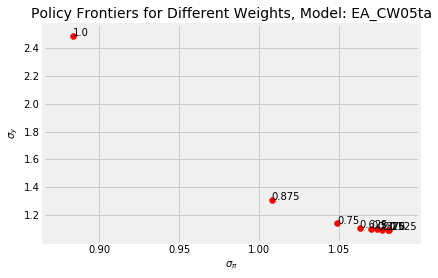

In [15]:
m34results = createFrontier(34)

In [16]:
m34results

,lambdas,inflation_variance,output_gap_variance,interest_variance,loss,coefficients
0,0.000,1.16860,1.1954,16.018,1.195724,"[0.1907884535316938, 0.0034048052145588988, 0...."
1,0.125,1.16700,1.1956,16.009,1.192106,"[0.1972328731233827, 0.003821557120927807, 0.9..."
2,0.250,1.15920,1.1972,16.008,1.187764,"[0.22964538136658869, 0.0031969847703125593, 0..."
3,0.375,1.15280,1.2002,16.008,1.182489,"[0.2560680754729011, 0.0029694052241527563, 1...."
4,0.500,1.14440,1.2071,16.005,1.175775,"[0.2913506186610594, 0.0028552353968771815, 1...."
5,0.625,1.12910,1.2272,16.006,1.165924,"[0.3566639135904265, 0.002844623119750724, 1.0..."
6,0.750,1.09970,1.2956,16.005,1.148700,"[0.4817219166106885, 0.0032120173843371066, 0...."
7,0.875,1.01570,1.7164,16.004,1.103303,"[0.7870056840827763, 0.0034165698249243154, 0...."
8,1.000,0.78106,6.1947,16.002,0.781064,"[1.1176415394101908, 0.005311785425389605, 0.1..."


Total PID Loss 1250.757089 lambda= 0.0
Total PID Loss 1479.9922639999995 lambda= 0.0
Total PID Loss 1251.463549 lambda= 0.0
Total PID Loss 1196.8508690000003 lambda= 0.0
Total PID Loss 1250.4734409999999 lambda= 0.0
Total PID Loss 1021.3620410000002 lambda= 0.0
Total PID Loss 831.6499249999998 lambda= 0.0
Total PID Loss 1003.7844249999999 lambda= 0.0
Total PID Loss 894.969676 lambda= 0.0
Total PID Loss 748.0861489999999 lambda= 0.0
Total PID Loss 561.5618159999999 lambda= 0.0
Total PID Loss 514.3635290000001 lambda= 0.0
Total PID Loss 298.93606900000015 lambda= 0.0
Total PID Loss 340.18437599999993 lambda= 0.0
Total PID Loss 216.80582500000003 lambda= 0.0
Total PID Loss 71.4843 lambda= 0.0
Total PID Loss 50.457228999999984 lambda= 0.0
Total PID Loss 2.1835010000000006 lambda= 0.0
Total PID Loss 2.3227209999999996 lambda= 0.0
Total PID Loss 7.285164000000003 lambda= 0.0
Total PID Loss 1.683749 lambda= 0.0
Total PID Loss 28.428448999999993 lambda= 0.0
Total PID Loss 3.1065240000000003 la

Total PID Loss 2.1102250000000002 lambda= 0.125
Total PID Loss 2.086566 lambda= 0.125
Total PID Loss 2.1102625 lambda= 0.125
Total PID Loss 2.5930499999999976 lambda= 0.125
Total PID Loss 2.110286 lambda= 0.125
Total PID Loss 2.543499999999999 lambda= 0.125
Total PID Loss 2.2119840000000006 lambda= 0.125
Total PID Loss 2.2273640000000006 lambda= 0.125
Total PID Loss 2.129059 lambda= 0.125
Total PID Loss 2.1361190000000008 lambda= 0.125
Total PID Loss 2.1091735000000003 lambda= 0.125
Total PID Loss 2.097291 lambda= 0.125
Total PID Loss 2.095199 lambda= 0.125
Total PID Loss 2.096574 lambda= 0.125
Total PID Loss 2.0756765 lambda= 0.125
Total PID Loss 2.059761 lambda= 0.125
Total PID Loss 2.0701035 lambda= 0.125
Total PID Loss 2.065801 lambda= 0.125
Total PID Loss 2.047675 lambda= 0.125
Total PID Loss 2.0333785000000004 lambda= 0.125
Total PID Loss 2.025866 lambda= 0.125
Total PID Loss 2.0060865 lambda= 0.125
Total PID Loss 2.0268625 lambda= 0.125
Total PID Loss 2.0075874999999996 lambda= 

Total PID Loss 2.313651 lambda= 0.25
Total PID Loss 2.313701 lambda= 0.25
Total PID Loss 2.3136 lambda= 0.25
Total PID Loss 2.313651 lambda= 0.25
Total PID Loss 2.313626 lambda= 0.25
Total PID Loss 2.313676 lambda= 0.25
Total PID Loss 2.313676 lambda= 0.25
Total PID Loss 2.313626 lambda= 0.25
Total PID Loss 2.313676 lambda= 0.25
Total PID Loss 2.313651 lambda= 0.25
Total PID Loss 2.313626 lambda= 0.25
Total PID Loss 2.313676 lambda= 0.25
Total PID Loss 2.313676 lambda= 0.25
Total PID Loss 2.313701 lambda= 0.25
Total PID Loss 2.313651 lambda= 0.25
Total PID Loss 2.313676 lambda= 0.25
Total PID Loss 2.313701 lambda= 0.25
Total PID Loss 2.313676 lambda= 0.25
Total PID Loss 2.313651 lambda= 0.25
Total PID Loss 2.313676 lambda= 0.25
Total PID Loss 2.313676 lambda= 0.25
Total PID Loss 2.5865874999999994 lambda= 0.375
Total PID Loss 2.6125940000000005 lambda= 0.375
Total PID Loss 2.5866249999999997 lambda= 0.375
Total PID Loss 2.808498500000001 lambda= 0.375
Total PID Loss 2.5865874999999994 

Total PID Loss 2.681 lambda= 0.5
Total PID Loss 2.680941 lambda= 0.5
Total PID Loss 2.681 lambda= 0.5
Total PID Loss 2.681 lambda= 0.5
Total PID Loss 2.681 lambda= 0.5
Total PID Loss 2.681 lambda= 0.5
Total PID Loss 2.681 lambda= 0.5
Total PID Loss 2.680941 lambda= 0.5
Total PID Loss 2.68105 lambda= 0.5
Total PID Loss 2.681 lambda= 0.5
Total PID Loss 2.6809410000000002 lambda= 0.5
Total PID Loss 2.680991 lambda= 0.5
Total PID Loss 2.7918909999999997 lambda= 0.625
Total PID Loss 2.944489 lambda= 0.625
Total PID Loss 2.7918909999999997 lambda= 0.625
Total PID Loss 2.8593765 lambda= 0.625
Total PID Loss 2.7918909999999997 lambda= 0.625
Total PID Loss 2.9094665 lambda= 0.625
Total PID Loss 2.8263749999999996 lambda= 0.625
Total PID Loss 2.8498589999999995 lambda= 0.625
Total PID Loss 2.8109015000000004 lambda= 0.625
Total PID Loss 2.7798235 lambda= 0.625
Total PID Loss 2.7997875 lambda= 0.625
Total PID Loss 2.8160160000000003 lambda= 0.625
Total PID Loss 2.792744 lambda= 0.625
Total PID Lo

Total PID Loss 2.800649 lambda= 0.75
Total PID Loss 2.800699 lambda= 0.75
Total PID Loss 2.800699 lambda= 0.75
Total PID Loss 2.8184365000000002 lambda= 0.875
Total PID Loss 3.0938389999999982 lambda= 0.875
Total PID Loss 2.818524 lambda= 0.875
Total PID Loss 2.8430159999999995 lambda= 0.875
Total PID Loss 2.818611 lambda= 0.875
Total PID Loss 3.0959035 lambda= 0.875
Total PID Loss 2.885200000000001 lambda= 0.875
Total PID Loss 2.8973249999999995 lambda= 0.875
Total PID Loss 2.8363765 lambda= 0.875
Total PID Loss 2.8069434999999996 lambda= 0.875
Total PID Loss 2.810044 lambda= 0.875
Total PID Loss 2.826776 lambda= 0.875
Total PID Loss 2.8162815 lambda= 0.875
Total PID Loss 2.8084940000000005 lambda= 0.875
Total PID Loss 2.8051435 lambda= 0.875
Total PID Loss 2.8025965 lambda= 0.875
Total PID Loss 2.802594 lambda= 0.875
Total PID Loss 2.8124835 lambda= 0.875
Total PID Loss 2.8134714999999995 lambda= 0.875
Total PID Loss 2.8048415 lambda= 0.875
Total PID Loss 2.8116209999999997 lambda= 0

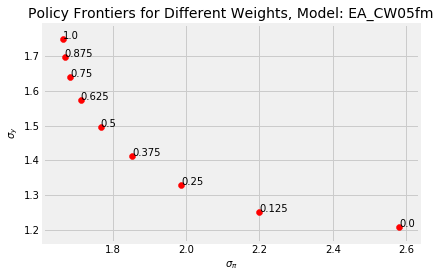

In [21]:
m35results = createFrontier(35)